In [ ]:
!git clone https://gitlab.com/UdaraDananjaya/Face-Mask-Detection

Step 1: Install Required Libraries



In [4]:
# Install required libraries (if not already available in Colab)
!pip install tensorflow opencv-python imutils matplotlib


Step 2: Imports



In [5]:
# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


Step 3: Constants



In [6]:
# Constants
INIT_LR = 1e-4
EPOCHS = 2 #20
BS = 32

# Update the DIRECTORY path to your dataset in Colab
DIRECTORY = "/content/Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]


Step 4: Data Loading



In [14]:
# Data loading
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Save the labels to a text file
with open("labels.txt", "w") as label_file:
    for index, label in enumerate(lb.classes_):
        label_file.write(f"{index} {label}\n")

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)



[INFO] loading images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 5: Model Construction




In [15]:
# Model construction
# Load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


Step 6: Model Training



In [16]:
# Model training
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Compile the model
print("[INFO] compiling model...")
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adam(learning_rate=INIT_LR)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/2
95/95 [==============================] - 52s 407ms/step - loss: 0.4474 - accuracy: 0.8214 - val_loss: 0.1548 - val_accuracy: 0.9791
Epoch 2/2
95/95 [==============================] - 37s 393ms/step - loss: 0.1519 - accuracy: 0.9611 - val_loss: 0.0784 - val_accuracy: 0.9870


Step 7: Model Evaluation and Saving



In [17]:
# Model evaluation and saving
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# Find the index of the label with the corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] evaluating network...
24/24 [==============================] - 2s 71ms/step
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Step 8: Plotting



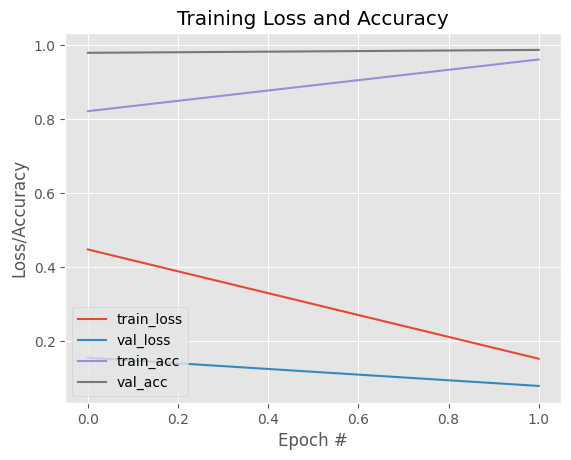

In [18]:
# Plotting
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


# Predict

In [21]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("mask_detector.model", compile=False)

# Load the labels
class_names = open("labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
#image = Image.open("/content/Face-Mask-Detection/dataset/without_mask/0.jpg").convert("RGB")
image = Image.open("1.jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 1s 772ms/step
Class: with_mask
Confidence Score: 0.9997894
